<a target="_blank" href="https://colab.research.google.com/github/olsenlabmit/Polymer-Ensemble-Similarity/blob/main/notebook/Example1_Two_Component_Polymer_Ensemble_Colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# @title Copyright & License (click to expand)

# MIT License

# Copyright (c) 2023 olsenlabmit

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Download the necessary local functions, tables, and dataset

In [ ]:
!git clone https://github.com/olsenlabmit/Polymer-Ensemble-Similarity.git
!mv Polymer-Ensemble-Similarity/dataset .
!mv Polymer-Ensemble-Similarity/tables .
!mv Polymer-Ensemble-Similarity/utils .

# Import the required library

In [16]:
import random
import numpy as np
import shutil
import sys
import os.path
import json
from scipy.stats import norm

if not shutil.which("rdkit"):
    !pip install -q rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

if not shutil.which("grakel"):
    !pip install grakel

if not shutil.which("dgl"):
    !pip install dgl

if not shutil.which("umap"):
    !pip install umap-learn

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert shutil.which("pyomo")

from pyomo.environ import *

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert shutil.which("cbc") or os.path.isfile("cbc")

from utils.load_networkx import networkx_feat
from utils import macro_unsupervised as unsup
from utils import plot

print("Import Library Done!")

Import Library Done!


# Load the Ensemble P and Ensemble Q in Example 1

In [29]:
Ensemble_P = networkx_feat(
    TXT_DATA_PATH="./dataset/Example1/Ensemble_P/",
    MON_SMILES="tables/SMILES_monomer.txt",
    FEAT="onehot",
)
print("Ensemble P: ")
Ensemble_P

Ensemble P: 


{'p1': <networkx.classes.graph.Graph at 0x78986c32ffd0>,
 'p2': <networkx.classes.graph.Graph at 0x78986c20bb20>}

{0: 'RX1', 1: 'RX2', 2: 'RX1', 3: 'RX2', 4: 'RX1', 5: 'RX2', 6: 'RX1', 7: 'RX2', 8: 'RX1'}


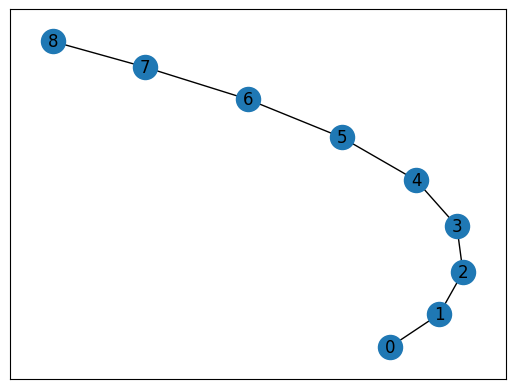

In [18]:
plot.graph(Ensemble_P["p1"])

{0: 'RX2', 1: 'RX1', 2: 'RX2', 3: 'RX1', 4: 'RX2', 5: 'RX1', 6: 'RX2', 7: 'RX1', 8: 'RX2'}


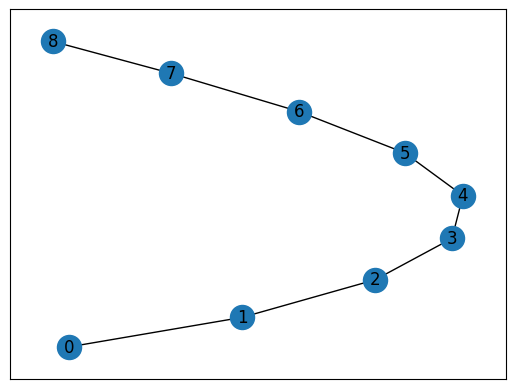

In [20]:
plot.graph(Ensemble_P["p2"])

In [28]:
Ensemble_Q = networkx_feat(
    TXT_DATA_PATH="./dataset/Example1/Ensemble_Q/",
    MON_SMILES="tables/SMILES_monomer.txt",
    FEAT="onehot",
)
print("Ensemble Q: ")
Ensemble_Q

Ensemble Q: 


{'q1': <networkx.classes.graph.Graph at 0x78986c32ff70>,
 'q2': <networkx.classes.graph.Graph at 0x78986c20b8e0>}

{0: 'RX1', 1: 'RX1', 2: 'RX1', 3: 'RX2', 4: 'RX2', 5: 'RX2', 6: 'RX1', 7: 'RX1', 8: 'RX1'}


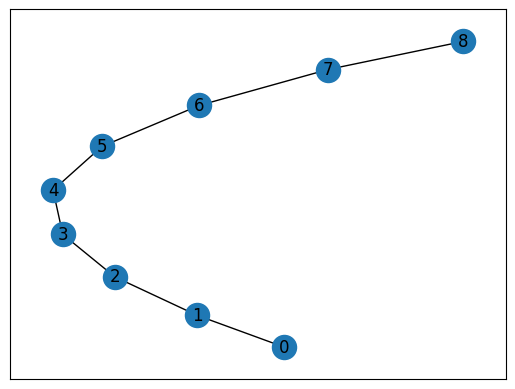

In [22]:
plot.graph(Ensemble_Q["q1"])

{0: 'RX2', 1: 'RX2', 2: 'RX2', 3: 'RX1', 4: 'RX1', 5: 'RX1', 6: 'RX2', 7: 'RX2', 8: 'RX2'}


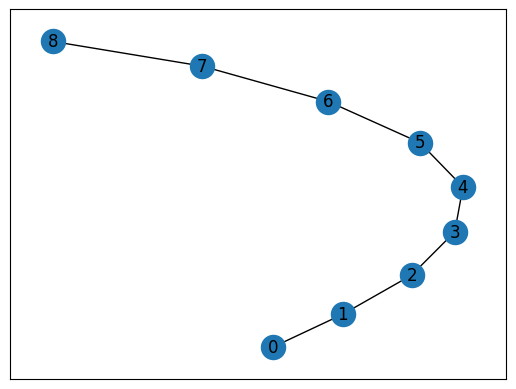

In [23]:
plot.graph(Ensemble_Q["q2"])

# EMD function

In [31]:
def Calculate_EMD(
    ensembleP=None,
    ensembleP_weight=None,
    ensembleQ=None,
    ensembleQ_weight=None,
    alpha=1,
    print_details=False,
):
    Demand = {}
    Supply = {}
    T = {}

    ensembleP_number = len(ensembleP_weight)

    ensembleP_weight_sum = sum(ensembleP_weight)

    ensembleP_indexs = list(ensembleP.keys())

    for i in range(0, ensembleP_number):
        Demand["P" + str(i + 1)] = ensembleP_weight[i] / ensembleP_weight_sum

    ensembleQ_number = len(ensembleQ_weight)

    ensembleQ_weight_sum = sum(ensembleQ_weight)

    ensembleQ_indexs = list(ensembleQ.keys())

    for j in range(0, ensembleQ_number):
        Supply["Q" + str(j + 1)] = ensembleQ_weight[j] / ensembleQ_weight_sum

    for i in range(0, ensembleP_number):
        for j in range(0, ensembleQ_number):
            GED = unsup.edit_distance(
                ensembleP[ensembleP_indexs[i]],
                ensembleQ[ensembleQ_indexs[j]],
                node_attr="h",
                edge_attr="e",
                upper_bound=100,
                indel_mul=1,
                sub_mul=1,
            )

            N_i = ensembleP[ensembleP_indexs[i]].number_of_nodes()

            N_j = ensembleQ[ensembleQ_indexs[j]].number_of_nodes()

            T[("P" + str(i + 1), "Q" + str(j + 1))] = 1 - np.exp(
                -alpha * GED / (0.5 * (N_i + N_j))
            )

    # Step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Step 1: Define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # Step 2: Define the decision
    model.x = Var(CUS, SRC, domain=NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
        expr=sum([T[c, s] * model.x[c, s] for c in CUS for s in SRC]), sense=minimize
    )

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c, s] for c in CUS]) <= Supply[s])

    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c, s] for s in SRC]) == Demand[c])

    results = SolverFactory("cbc").solve(model)

    if "ok" == str(results.Solver.status):
        if print_details == True:
            for s in SRC:
                for c in CUS:
                    if model.x[c, s]() > 0:
                        print(
                            "Ship from ",
                            s,
                            " to ",
                            c,
                            ":",
                            model.x[c, s](),
                            "*",
                            T[c, s],
                        )
        return model.Cost()

    else:
        print("No Valid Solution Found")
        return False

# The calculation of EMD(P,Q) and S(P,Q)

In [32]:
EMD = Calculate_EMD(
    ensembleP=Ensemble_P,
    ensembleP_weight=[0.5, 0.5],
    ensembleQ=Ensemble_Q,
    ensembleQ_weight=[0.5, 0.5],
    alpha=1,
    print_details=False,
)

print("EMD(P,Q) = ", EMD)
print("S(P,Q) = ", 1 - EMD)

EMD(P,Q) =  0.28346868942621073
S(P,Q) =  0.7165313105737893
